# Feature Selection
Below we will go over some tips and tricks for feature selection which may prove helpful. In particular we will be look at some statistical tests and some relationships between inputs/outputs that can help reduce the complexity of the model and may offer better performance. We will be looking at:

<u>Pre-Training</u>
1) Anova F-Test
2) Correlation Test
3) Variance Score
4) Mutual Information

<u>Post-Training</u>
1) Feature Importance

In [3]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import librosa 
import librosa.display
import IPython.display as ipd

from glob import glob
import opendatasets as od 

## Dataset
For this notebook we will use the major-vs-minor guitar chords data set which can be found at: and downloaded using the code below. 

In [4]:
od.download('https://www.kaggle.com/datasets/mehanat96/major-vs-minor-guitar-chords/data')

Skipping, found downloaded files in ".\major-vs-minor-guitar-chords" (use force=True to force download)


In [59]:
def feature_extraction(path):
    y,sr = librosa.load(path)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=16,n_fft=1024//4 )#

    # Convert an amplitude spectrogram to Decibels-scaled spectrogram.
    DB = librosa.amplitude_to_db(chroma_stft, ref = np.max)
    
    # Scale the extracted features
    extracted_features = np.concatenate((np.mean(DB.T,axis=0),np.std(DB.T,axis=0)))
    
    return extracted_features

In [85]:
path = 'major-vs-minor-guitar-chords/shords_dataset/'

data = []
max_harm_length = 0 # for track of max harmonic length to name columns

for dirn, _, files in os.walk(path):
    for file in files:
        folder = os.path.basename(dirn)
        full_path = os.path.join(dirn, file)
        freq_peaks = feature_extraction(full_path)
        
        cur_data = [folder]
        cur_data.extend(freq_peaks)
        
        data.append(cur_data)

data = pd.DataFrame(data)

In [86]:
data

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,major,-3.668096,-2.936436,-2.473215,-2.121809,-1.732175,-1.371640,-1.087541,-0.938765,-1.086269,...,1.585322,1.758497,1.931221,2.052912,1.938572,1.826244,1.779271,1.763245,1.761104,1.987432
1,major,-6.483990,-5.602185,-4.105858,-2.828231,-2.260083,-2.130304,-2.255524,-1.877439,-1.129837,...,4.903658,3.704822,1.757789,2.058336,3.846125,4.680800,3.898610,3.773968,2.733048,2.737029
2,major,-6.060093,-4.978780,-4.073983,-3.229052,-2.327367,-1.383513,-0.586808,-0.110066,-0.152913,...,0.375194,0.193944,0.292507,0.477588,0.625216,0.849684,1.175838,1.591074,2.080880,2.665120
3,major,-5.335945,-4.337996,-3.416936,-2.458807,-1.458970,-0.684919,-0.235624,-0.244408,-0.741816,...,0.842358,0.896655,0.980007,1.008300,1.054285,1.248376,1.500547,1.787059,2.280643,2.943132
4,major,-3.313956,-2.421612,-1.839295,-1.424736,-1.083825,-0.827480,-0.608456,-0.514521,-0.775081,...,0.835279,1.031529,1.231479,1.398404,1.346191,1.218183,1.094226,1.099374,1.463737,2.028674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,minor,-2.526153,-2.207192,-2.178334,-2.223286,-2.118447,-1.908156,-1.684667,-1.562972,-1.794082,...,1.800797,2.089443,2.182585,1.940065,1.527301,1.508947,1.754816,1.883447,1.874141,2.015280
498,minor,-4.552196,-5.396957,-5.918535,-5.718040,-4.952560,-4.231732,-3.707443,-3.301100,-2.969919,...,2.482713,2.497441,2.270147,1.693588,1.223945,0.926184,0.901880,0.957445,1.022012,1.506518
499,minor,-2.535743,-2.361215,-2.987305,-3.832317,-4.281572,-4.094162,-3.674114,-3.213186,-2.994137,...,2.547895,2.917538,3.109025,2.891443,2.941004,2.908880,2.872799,2.807985,2.488734,2.396461
500,minor,-3.373635,-2.768179,-3.171872,-3.843138,-4.339002,-4.466363,-3.588641,-2.926975,-2.911242,...,2.857141,3.055362,3.091341,2.326104,2.003223,2.239434,2.452028,2.833519,2.982075,3.240048


### Train a Model

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [140]:
X = data.drop(0, axis=1)  # Features
y = data[0]  # Target variable"

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=50)
rfmodel = RandomForestClassifier().fit(X_train,y_train)
y_pred_train = rfmodel.predict(X_train)
y_pred_test = rfmodel.predict(X_test)

print(f'Training Accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Testing Accuracy: {accuracy_score(y_test,y_pred_test)}')

Training Accuracy: 1.0
Testing Accuracy: 0.594059405940594


## Pre-Training a Model
One approach to feature selection is to identify non-substantial features for a given output before we train a model. This approach either requires some a-priori information about the connection from the features to the desired output or requires some 

## Anova F-Test

In [63]:
from sklearn.feature_selection import SelectKBest, f_classif

In [141]:
fs = SelectKBest(score_func=f_classif, k=25)
fs.fit(X_train, y_train)

# transform train input data
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [142]:
rfmodel = RandomForestClassifier().fit(X_train_fs,y_train)
y_pred_train = rfmodel.predict(X_train_fs)
y_pred_test = rfmodel.predict(X_test_fs)

print(f'Training Accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Testing Accuracy: {accuracy_score(y_test,y_pred_test)}')

Training Accuracy: 1.0
Testing Accuracy: 0.5346534653465347


By removing a few of the features from our model, our performances degrades slightly but overall still has similar accuracy to the initial model. This approach 

## Mutual Information
The measure of mutual dependence between two random variables. This helps identify the amount of information obtained from the input to the output. 

$$
    I(X;Y) = \sum_{x \in X}\sum_{y \in Y} p(x,y)\log(\frac{p(x,y)}{p(x)p(y)})
$$
where p(x,y) is the joint probability of the input variable and the output variable, p(x) and p(y) is the marginal probabilities of X and Y respectively

In [67]:
from sklearn.feature_selection import mutual_info_classif

<BarContainer object of 32 artists>

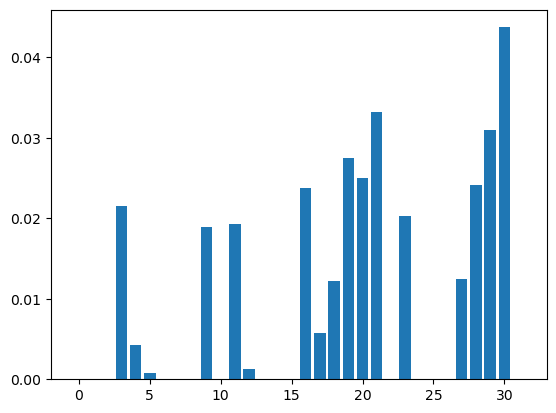

In [69]:
plt.bar(np.arange(0,32,1),mutual_info_classif(X_train, y_train))
plt.ylabel('Mutual information')
plt.xlabel('Feature')
plt.show()

In [98]:
MI = mutual_info_classif(X_train, y_train)
selfeatures = MI>np.mean(MI)
X_train_mi = X_train.loc[:, selfeatures]
X_test_mi = X_test.loc[:,selfeatures]

In [100]:
rfmodel = RandomForestClassifier().fit(X_train_mi,y_train)
y_pred_train = rfmodel.predict(X_train_mi)
y_pred_test = rfmodel.predict(X_test_mi)

print(f'Training Accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Testing Accuracy: {accuracy_score(y_test,y_pred_test)}')

Training Accuracy: 1.0
Testing Accuracy: 0.5544554455445545


## Variance 
Variance is the 
$$
    V(x) = 
$$


In [103]:
from sklearn.feature_selection import VarianceThreshold

In [125]:
vt = VarianceThreshold(threshold=3).fit(X_train)
X_train_vt = vt.transform(X_train)
X_test_vt = vt.transform(X_test)

In [126]:
rfmodel = RandomForestClassifier().fit(X_train_vt,y_train)
y_pred_train = rfmodel.predict(X_train_vt)
y_pred_test = rfmodel.predict(X_test_vt)

print(f'Training Accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Testing Accuracy: {accuracy_score(y_test,y_pred_test)}')

Training Accuracy: 1.0
Testing Accuracy: 0.5445544554455446


## Correlation

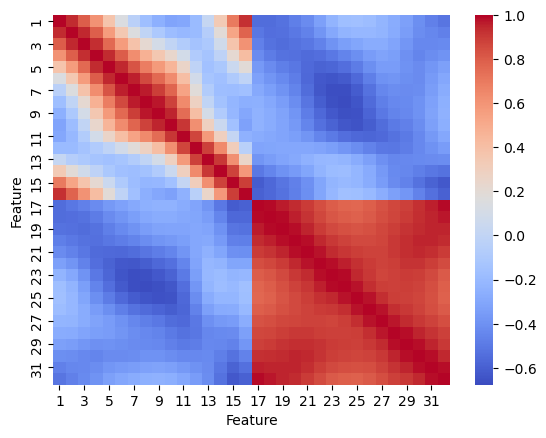

In [130]:
corr_matrix = X_train.corr() 
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.ylabel('Feature')
plt.xlabel('Feature')
plt.show()

The above plot shows the correlations between 

In [134]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.7  # Set your correlation threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

X_train_corr = X_train.drop(to_drop, axis=1)
X_test_corr = X_test.drop(to_drop, axis = 1)

In [151]:
rfmodel = RandomForestClassifier().fit(X_train_corr,y_train)
y_pred_train = rfmodel.predict(X_train_corr)
y_pred_test = rfmodel.predict(X_test_corr)

print(f'Training Accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Testing Accuracy: {accuracy_score(y_test,y_pred_test)}')

Training Accuracy: 1.0
Testing Accuracy: 0.6138613861386139


In the above example we can see that the model is tending to predict better. This is because the model has less complexity (less features) to parse through and is provided with the most relevant information for prediction. 

## Post Training a Model
Another popular approach to feature selection is by first training a model with all of the features and then identifying a few features which have the highest impact on the overall performance. Several post training explainable AI techniques exist such as feature permutation, SHapley Additive exPlanations, or Local Interpretable Model-Agnostic Explanations (of which we cover in the Explainable AI notebook). Through these techniques, we can retrain a model with a smaller subset of features as shown below.

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [153]:
X = data.drop(0, axis=1)  # Features
y = data[0]  # Target variable"

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=50)
rfmodel = RandomForestClassifier().fit(X_train,y_train)
y_pred_train = rfmodel.predict(X_train)
y_pred_test = rfmodel.predict(X_test)

print(f'Training Accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Testing Accuracy: {accuracy_score(y_test,y_pred_test)}')

Training Accuracy: 1.0
Testing Accuracy: 0.6039603960396039


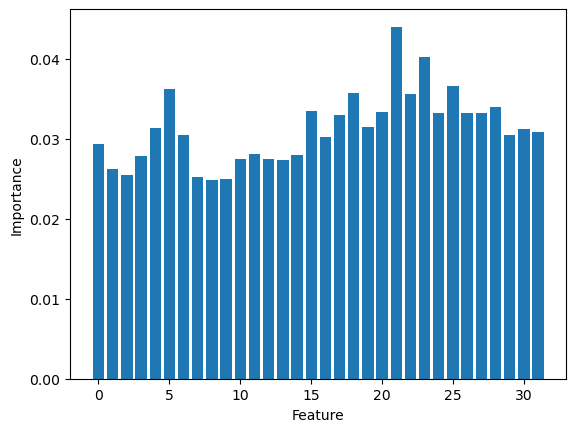

In [158]:
importances = rfmodel.feature_importances_
plt.bar(np.arange(0,len(importances),1),importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

The above feature importance is computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [173]:
numfeatures = 12
ind = np.argpartition(importances, -numfeatures)[-numfeatures:]

X_train_nf = X_train.iloc[:,ind]
X_test_nf = X_test.iloc[:,ind]

rfmodel = RandomForestClassifier().fit(X_train_nf,y_train)
y_pred_train = rfmodel.predict(X_train_nf)
y_pred_test = rfmodel.predict(X_test_nf)

print(f'Training Accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Testing Accuracy: {accuracy_score(y_test,y_pred_test)}')

Training Accuracy: 1.0
Testing Accuracy: 0.5643564356435643


# Citations
